In [1]:
import os
import json
import re
import time
import pandas as pd
from collections import Counter

twitter_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "twitter.json")

with open(twitter_path) as json_file:  
    twitter_raw = json.load(json_file)
twitter = twitter_raw['rows']

In [2]:
# collect all important information from twitter dataset
docid = []
area = []
month = []
userid = []
text = []
coordinates = []
retweet_count = []
followers_count = []
friends_count = []
hashtag = []
reply = []
media_type = []
polygon = []
polygonid = []
polygon_dict = {}
for i in range(len(twitter)):    
    docid.append(twitter[i]['id'])
    area.append(twitter[i]['key'][0])    
    month.append(twitter[i]['key'][2]) 
    userid.append(twitter[i]['doc']['user']['id'])
    coordinates.append(twitter[i]['doc']['coordinates']['coordinates'])
    retweet_count.append(twitter[i]['doc']['retweet_count'])        
    followers_count.append(twitter[i]['doc']['user']['followers_count'])     
    friends_count.append(twitter[i]['doc']['user']['friends_count'])     
    tweet = twitter[i]['doc']['text'].lower()
    tweet = re.sub(r"http\S+", "", tweet)
    hashtag.append(re.findall(r"#(\w+)", tweet)) 
    mentions = len(twitter[i]['doc']['entities']['user_mentions'])
    if mentions > 0:
        reply.append([twitter[i]['doc']['entities']['user_mentions'][x]['screen_name'].lower() for x in range(mentions)])
        for user in reply[i]:
            tweet = re.sub(r'@'+user+'\s','',tweet)
        text.append(tweet)
    else:
        reply.append([''])
        text.append(tweet)
    try:
        media = twitter[i]['doc']['entities']['media']
        media_type.append([media[x]['type'] for x in range(len(media))])
    except:
        media_type.append([''])
    try:
        pol = twitter[i]['doc']['place']['bounding_box']['coordinates'][0]
        polygon.append(pol)
        polygon_str = str([pol[0][0], pol[0][1], pol[1][0], pol[1][1], pol[2][0], pol[2][1], pol[3][0], pol[3][1]])
        if polygon_str not in polygon_dict.keys():
            polygon_dict[polygon_str] = len(polygon_dict) + 1  
        polygonid.append(polygon_dict[polygon_str])
    except:
        polygon.append([''])
        polygonid.append(0)       

In [4]:
# store the list in a data frame
dt = pd.DataFrame({'docid' : docid, 'area' : area , 'month' : month,
                   'userid' : userid, 'text' : text, 'coordinates' :coordinates,
                   'reply' : reply, 'retweet_count' : retweet_count,
                   'followers_count' : followers_count, 'friends_count' : friends_count,
                   'hashtag' : hashtag, 'media_type' : media_type, 'polygon' : polygon,
                   'polygonid' : polygonid}) 

In [35]:
# rules to determine the 7 sins in Social Media
import nltk
from thesaurus import Word
from textblob import TextBlob

def keylist(keywords):
    keylist = []
    keylist.extend(keywords)
    for key in keywords:
        thes = Word(key)
        thes_list = thes.synonyms('all')
        for syn in thes_list[0]:           
            keylist.append(syn)
    return set(keylist)

def check_keyword(row,keys):
    flag = 0
    for key in keys:
        if key in row['text']:
            flag = 1
    return flag

def check_keyword_retweet(row,keys):
    flag = 0
    for key in keys:
        if key in row['text']:
            flag = 1
    if row['retweet_count'] > 0:
        flag = 1
    return flag

def find_tag(text):
    tags = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tags)
    tag_order = []
    for tag in tags:
        tag_order.append(tag[1])
    return tag_order

def check_tag(row,taglist):
    texttag = find_tag(row['text'])
    flag = 0
    for i in range(len(texttag)):   
        trigram = texttag[i:i+3]
        if trigram == taglist:
            flag = 1
    return flag

def check_sentiment(row):
    flag = 0
    analysis = TextBlob(row['text'])
    polarity = analysis.sentiment[0]
    if polarity < 0:
        flag = 1
    return flag

In [ ]:
# add flag column to the data frame for each sin
gluttony_key = keylist(['food','meal'])
dt['gluttony_flag'] = dt.apply(lambda row: check_keyword(row,gluttony_key), axis=1)

lust_key = keylist(['sex','sexual','desire','passion'])
dt['lust_flag'] = dt.apply(lambda row: check_keyword(row,lust_key), axis=1)

greed_key = keylist(['money','rich','wealth'])
dt['greed_flag'] = dt.apply(lambda row: check_keyword(row,greed_key), axis=1)

envy_key = keylist(['wish','need','want'])
dt['envy_flag'] = dt.apply(lambda row: check_keyword(row,envy_key), axis=1)

lust_key = keylist(['lazy'])
dt['lust_flag'] = dt.apply(lambda row: check_keyword_retweet(row,lust_key), axis=1)

pride_tag = ['DT', 'JJ', 'NN']
dt['pride_flag'] = dt.apply(lambda row: check_tag(row,pride_tag), axis=1)

dt['wrath_flag'] = dt.apply(lambda row: check_sentiment(row), axis=1)

In [38]:
def total_sins(row):
    total_sins = row['gluttony_flag'] + row['lust_flag'] + row['greed_flag'] + \
                 row['envy_flag'] + row['lust_flag'] + row['pride_flag'] + row['wrath_flag']
    return total_sins

dt['total_sins'] = dt.apply(lambda row: total_sins(row), axis=1) 

In [44]:
dt.head(3)

,docid,area,month,userid,text,coordinates,reply,retweet_count,followers_count,friends_count,...,media_type,polygon,polygonid,gluttony_flag,lust_flag,greed_flag,envy_flag,pride_flag,wrath_flag,total_sins
0,493771212414140417,perth,7,629840969,because its like the worst possible thing to h...,"[116.00698778, -32.23389833]","[cctimtan, shxni, omgitsissi]",0,383,539,...,[],"[[115.617614368, -32.675715325], [116.23902300...",1,0,0,0,1,0,1,2
1,493771233511489536,perth,7,2191652293,perfect 😍😘,"[115.92057324, -31.87855089]","[jaibrooks1, nashgrier]",0,312,478,...,[photo],"[[115.617614368, -32.675715325], [116.23902300...",1,0,0,0,0,0,0,0
2,493771342173306880,perth,7,2191652293,😏,"[115.92056523, -31.87855063]",[brooksbeau],0,312,478,...,[photo],"[[115.617614368, -32.675715325], [116.23902300...",1,0,0,0,0,0,0,0


In [46]:
dt.groupby(['polygonid']).agg({
            'gluttony_flag':'sum', \
            'lust_flag':'sum', \
            'greed_flag':'sum', \
            'envy_flag':'sum', \
            'lust_flag':'sum', \
            'pride_flag':'sum', \
            'wrath_flag':'sum', \
            'total_sins':'sum'}).head(5)

,gluttony_flag,lust_flag,greed_flag,envy_flag,pride_flag,wrath_flag,total_sins
polygonid,,,,,,,
0,3,1,4,7,10,9,35
1,11823,5064,6569,21639,14790,21763,86712
2,38,19,20,234,74,93,497
3,1,2,3,6,7,2,23
4,8,6,2,6,8,10,46


In [81]:
dt[['text']].loc[dt['total_sins'] >= 1].head(5)

,text
0,because its like the worst possible thing to happen tim its like demons are bad and dean is good 😭😭😭
3,sanchez is d only exciting player we av signed.we need a dm and a fw. nothing about us has changed.
6,really missing arianne tonight. so i changed my whatsapp photo to the both of us. @ ywam perth
7,the difference between arsenal and other teams last season was attack. we need a goal machine and a dmf
11,"a relief worker in #gaza says the sound of firing has increased in the area, despite a temporary lull in fighting:"


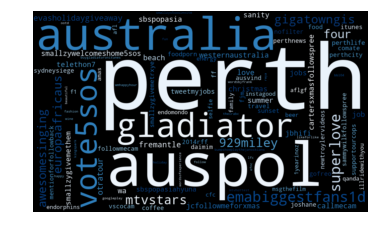

In [82]:
# Global hashtag

from wordcloud import WordCloud
import matplotlib.pyplot as plt

hashtag_dict = {}
for hlist in hashtag:
    for tag in hlist:    
        hashtag_dict[tag] = hashtag_dict.get(tag,0) + 1 

wordcloud = WordCloud(width=1000, height=600, colormap="Blues",max_words=100).generate_from_frequencies(hashtag_dict)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()